In [1]:
import pickle
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_pickle(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)
        return data

In [3]:
def flatten_data(data):
    flat_list_of_arrays = [item for sublist in data for item in sublist]
    data = np.vstack(flat_list_of_arrays)
    return data

In [4]:
pca = PCA(n_components=2, random_state=42)

In [5]:
yake_data = load_pickle('yake_embeddings.pkl')
textrank_data = load_pickle('textrank_embeddings.pkl')
bert_data = load_pickle('bert_embeddings.pkl')
all_data = np.concatenate([yake_data, textrank_data, bert_data], axis=0)
flattened_data = flatten_data(all_data)
embedded_data = pca.fit_transform(flattened_data)

yake_data = embedded_data[:int(len(embedded_data)/3)]
textrank_data = embedded_data[int(len(embedded_data)/3):int(2 * len(embedded_data)/3)]
bert_data = embedded_data[int(2 * len(embedded_data)/3):int(len(embedded_data))]

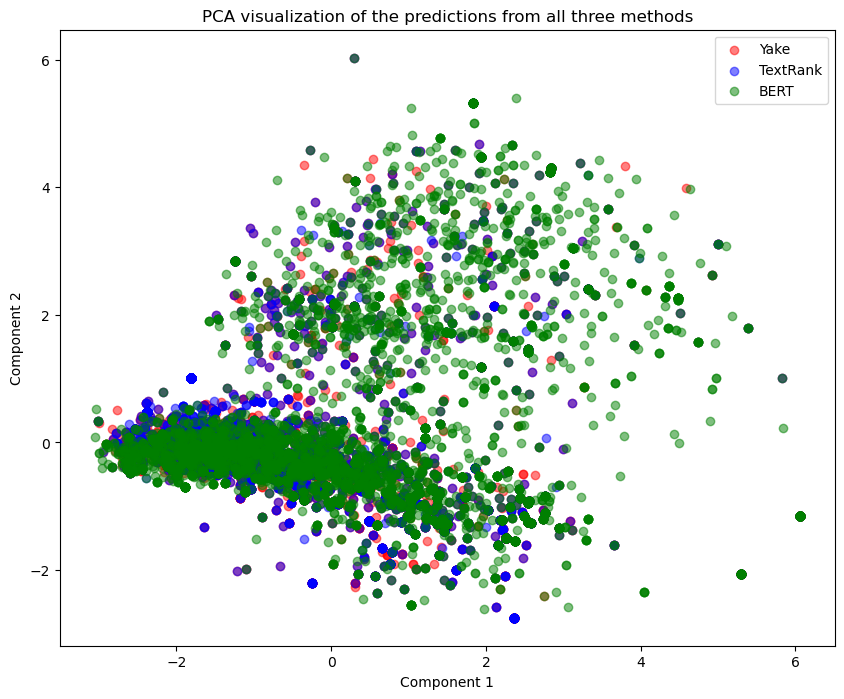

In [34]:
plt.figure(figsize=(10, 8))

plt.scatter(yake_data[:, 0], yake_data[:, 1], c='red', label='Yake', alpha=0.5)
plt.scatter(textrank_data[:, 0], textrank_data[:, 1], c='blue', label='TextRank', alpha=0.5)
plt.scatter(bert_data[:, 0], bert_data[:, 1], c='green', label='BERT', alpha=0.5)

plt.title('PCA visualization of the predictions from all three methods')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [7]:
import pandas as pd
import json

In [8]:
keywords = pd.read_csv('keywords_merged.csv')
keywords['BertKeyWords'] = keywords['BertKeyWords'].apply(json.loads)
keywords['YakeKeyWords'] = keywords['YakeKeyWords'].apply(json.loads)
keywords['TextRankKeywords'] = keywords['TextRankKeywords'].apply(json.loads)

In [9]:
from adjustText import adjust_text

In [23]:
def generate_plots(text_num, embeddings1, embeddings2, col_name1, col_name2):
    upper_limit = text_num * 10
    lower_limit = upper_limit - 10
    plt.figure(figsize=(10, 8))

    x_yake, y_yake = embeddings1[lower_limit:upper_limit, 0], embeddings1[lower_limit:upper_limit, 1]
    plt.scatter(x_yake, y_yake, c='red', label=col_name1, alpha=0.5)

    texts = []
    for i, (x, y) in enumerate(zip(x_yake, y_yake)):
        texts.append(plt.text(x, y, keywords[col_name1][text_num - 1][i], ha='center', va='center'))

    x_bert, y_bert = embeddings2[lower_limit:upper_limit, 0], embeddings2[lower_limit:upper_limit, 1]
    plt.scatter(x_bert, y_bert, c='green', label=col_name2, alpha=0.5)
    for i, (x, y) in enumerate(zip(x_bert, y_bert)):
        texts.append(plt.text(x, y, keywords[col_name2][text_num - 1][i], ha='center', va='center'))

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.title('PCA visualization of Keyword Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

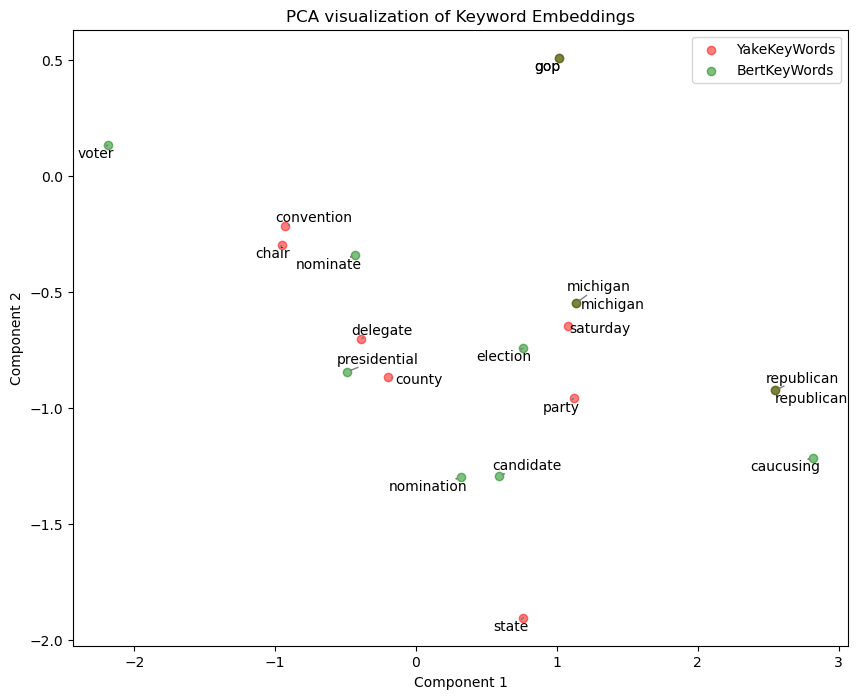

In [24]:
generate_plots(1, yake_data, bert_data,'YakeKeyWords', 'BertKeyWords')

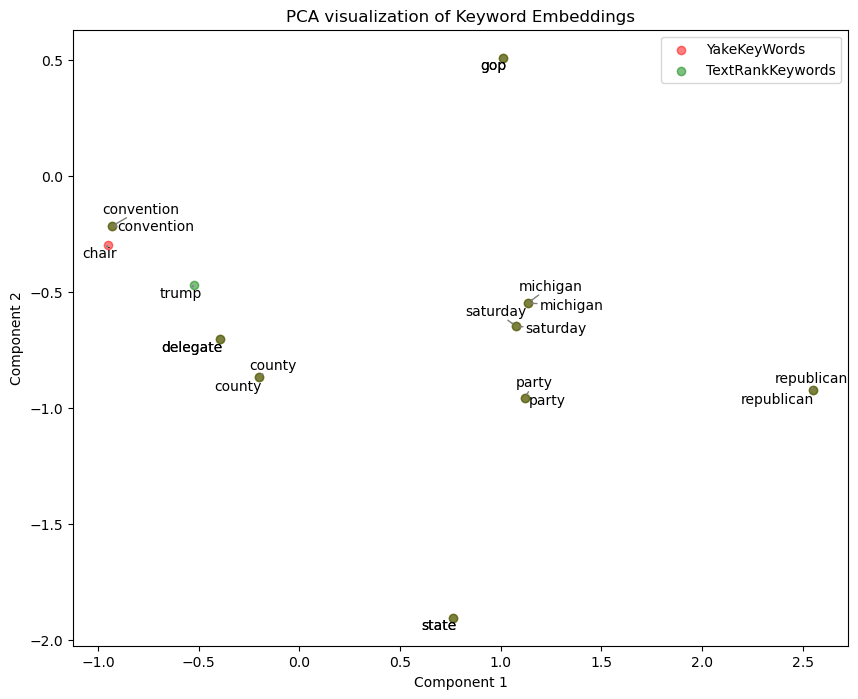

In [25]:
generate_plots(1, yake_data, textrank_data, 'YakeKeyWords', 'TextRankKeywords')

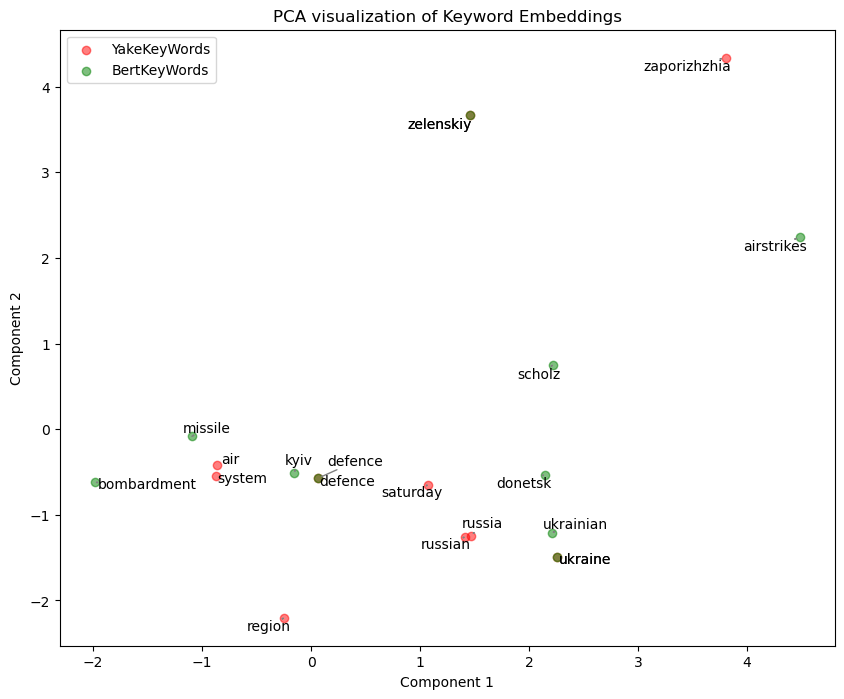

In [30]:
generate_plots(224, yake_data, bert_data,'YakeKeyWords', 'BertKeyWords')

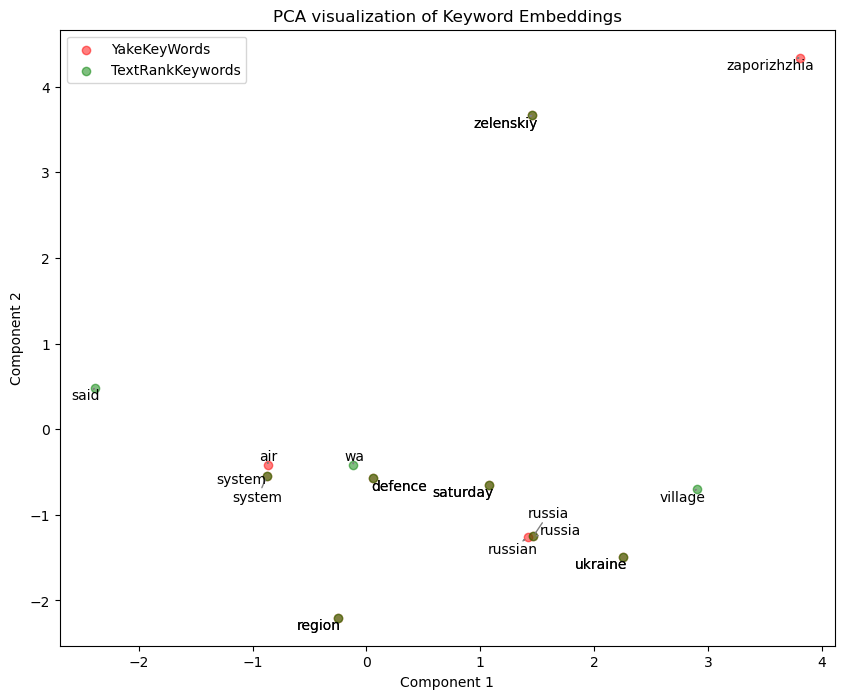

In [31]:
generate_plots(224, yake_data, textrank_data, 'YakeKeyWords', 'TextRankKeywords')